<a>
    <div style="margin: 10px;">
        <p align="center">
            <img width="40%" align="center" style="margin-right: 250px;" src="./images/spam.png"/>           
        </p>
    </div>
</a>

# Sumário

1. [Introdução](#Introdução)<br>
    1.1. [Objetivo](#objetivo)<br>
2. [Análise exploratória de dados](#eda)<br>

3. [Feature Engineering](#featureengineering)<br>
    3.1. [Verificando se o dataset está com as classes balançeadas](#balance)<br>
    &#x200B; 3.1.1. [Downsampling](#down)<br>
    3.2. [Número de caracteres](#numero)<br>
    3.3. [Número de caracteres em caixa alta](#caixaalta)<br>
    3.4. [Número de caracteres que são digitos](#caracdigit)<br>
    3.5. [Normalizando os dados](#norma)<br>
    3.6. [Term Frequency-Inverse Document Frequency (TF-IDF)](#tfidf)<br>
    
4. [Criando modelos](#modelos)<br>
    4.1. [Avaliando os modelos](#avaliando)<br>

5. [Aplicando o modelo nos dados de validação](#aplicando)<br>

6. [Referências](#ref)<br>

# 1. Introdução <a name="Introdução"></a>

O spam para celular ou SMS é um problema real e crescente, principalmente devido à disponibilidade de pacotes SMS pré-pagosmuito baratos e o fato de o SMS gerar taxas de resposta mais altas, pois é um serviço confiável e pessoal (Delany, S.J. 2012). A filtragem de spam por SMS é uma tarefa relativamente nova que herda muitos problemas e soluções de
filtragem de spam por email. No entanto, apresenta seus próprios desafios específicos. Este notebook demonstra algumas soluções atuais.

## 1.1 Objetivo <a name="objetivo"></a>
Foram disponibilizados dois datasets: **train_data.csv** e **validation_data.csv**.
O arquivo train_data.csv possui 2 colunas: **SMS** e **LABEL** e o arquivo validation_data.csv possui 1 coluna: SMS. 

Deve-se usar os modelos treinados a partir do dataset train_data.csv para aplicar as labels “blocked” ou “ok” a cada um dos SMS deste dataset.

# 2. Análise exploratória de dados <a name="eda"></a>

In [1]:
from functions import *
%matplotlib inline

* Verificando estrutura dos dados:

In [2]:
train_data = pd.read_csv("train_data.csv")
train_data.head()

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked


* Número de exemplos no dataset:

In [3]:
train_data.shape

(6000, 2)

* Verificando se alguns SMS se repetem com frequência:

In [4]:
train_data.groupby('LABEL').describe()

SMS                                                               
        count unique                                                top freq
LABEL                                                                       
blocked  1500   1495  Mercado BTC - Ha uma nova mensagem pendente. h...    3
ok       4500   4364                      131.221.110.19 DNS-SECUNDARIO   13

Pode-se ver que das 1500 mensagens que são spam, somente 5 são repetidas 

* usando WordCloud, pode-se ver como são as mensagens mais frequentes classificadas como spam:

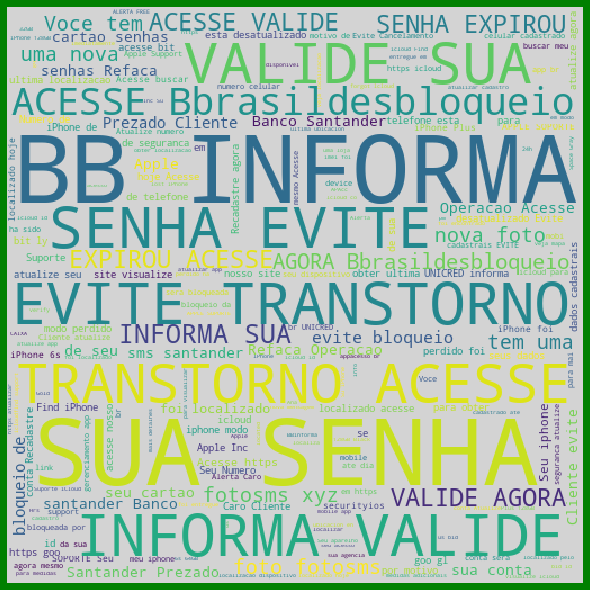

In [5]:
plot_wordcloud(train_data)

# 3. Feature Engineering <a name="featureengineering"></a>

Em (Tran et al., 2014), foram usadas principalmente as seguintes features em headers de e-mails para classificar spam, e dado que SMS tem semalhança com headers, também pode ser válido usar estas técnicas em cada SMS:
* Número de caracteres
* Número de caracteres em caixa alta
* Número de caracteres que são dígitos
* Term Frequency-Inverse Document Frequency (TF-IDF)

## 3.1. Verificando se o dataset está com as classes balançeadas <a name="balance"></a>

* Avaliando distribuição dos labels:

In [6]:
train_data['LABEL'].value_counts()

ok         4500
blocked    1500
Name: LABEL, dtype: int64

* Pode ser visto que o dataset está desbalançeado, com 3 vezes mais SMS verdadeiros que spam, então é interessante igualar essas classes para não criar um modelo com viés:

### 3.1.1. Downsampling <a name="down"></a>

Para resolver a questão de balanceamento do dataset, existem duas opçoes:
* Fazer cópias da classe com menor amostragem (upsampling) 
* Equilibrar as classes reduzindo o número de amostras da classe com mais exemplos (downsampling)

Vamos primeiro observar a eficácia do downsampling:

In [7]:
from sklearn.utils import resample

not_spam = train_data[train_data['LABEL']=='ok']
spam = train_data[train_data['LABEL']=='blocked']

not_spam_downsampled = resample(not_spam,
                                replace = False,
                                n_samples = len(spam), 
                                random_state = 42)

downsampled = pd.concat([not_spam_downsampled, spam])

print('Distribuição após downsampling:')
print(downsampled['LABEL'].value_counts())

Distribuição após downsampling:
blocked    1500
ok         1500
Name: LABEL, dtype: int64


## 3.2. Número de caracteres <a name="numero"></a>

* Criando feature com a quantidade de caracteres de cada mensagem:

In [8]:
downsampled['TAMANHO'] = downsampled['SMS'].apply(len)
downsampled.head()

,SMS,LABEL,TAMANHO
3823,Osirnet: Seu ip e 132.255.146.39. a Osirnet ag...,ok,62
5186,0500034B0201|Faça login no aplicativo OlympTra...,ok,80
4474,Zabbix_Alfa: PROBLEMA: ISP_BenoitIndisponivel\...,ok,101
4492,Zabbix_Alfa: PROBLEMA: ISP_Teutonet (Seitel)In...,ok,112
1968,"Ei, Adilur, seu CPF 030-xxx.xxx-44 pode sair d...",ok,148


# Estatisticas para Número de caractéres na mensagem
mean-ok  106.12   mean-spam 97.06 
std-ok   41.77   std-spam   28.77 
min-ok    18.00   min-spam    13.00 
max-ok  174.00   max-spam  170.00


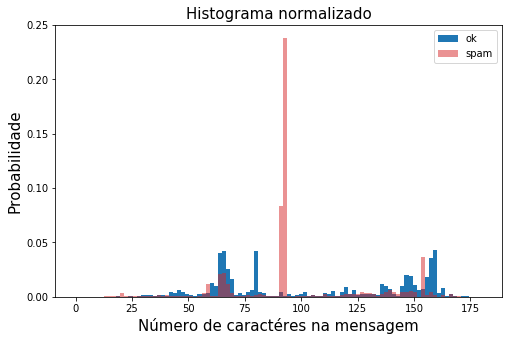

In [9]:
ok_messages = downsampled[downsampled['LABEL'] == 'ok']['TAMANHO']
spam_messages = downsampled[downsampled['LABEL'] == 'blocked']['TAMANHO']
plot_histogram(ok_messages,
               spam_messages, [0, 180],
               xlabel='Número de caractéres na mensagem')

- Pode ser visto que essa feature é uma boa candidata para classificação, já que a maioria dos spams tem um comprimento de caractéres entre 90 e 95, e o mesmo não ocorre para as mensagens que não são spam

## 3.3. Número de caracteres em caixa alta <a name="caixaalta"></a>

* Criando feature com a quantidade de caracteres em caixa alta de cada mensagem:

In [10]:
downsampled['UPPER_CASE'] = downsampled['SMS'].apply(upper_case_count)
downsampled.head()

,SMS,LABEL,TAMANHO,UPPER_CASE
3823,Osirnet: Seu ip e 132.255.146.39. a Osirnet ag...,ok,62,3
5186,0500034B0201|Faça login no aplicativo OlympTra...,ok,80,8
4474,Zabbix_Alfa: PROBLEMA: ISP_BenoitIndisponivel\...,ok,101,18
4492,Zabbix_Alfa: PROBLEMA: ISP_Teutonet (Seitel)In...,ok,112,19
1968,"Ei, Adilur, seu CPF 030-xxx.xxx-44 pode sair d...",ok,148,6


# Estatisticas para Número de caracteres em caixa alta
mean-ok  13.35   mean-spam 32.62 
std-ok   10.76   std-spam   22.04 
min-ok    0.00   min-spam    0.00 
max-ok  93.00   max-spam  103.00


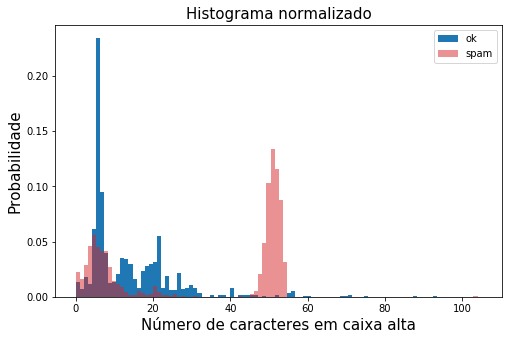

In [11]:
ok_messages = downsampled[downsampled['LABEL'] == 'ok']['UPPER_CASE']
spam_messages = downsampled[downsampled['LABEL'] == 'blocked']['UPPER_CASE']
plot_histogram(ok_messages,
               spam_messages, [0, 105],
               xlabel='Número de caracteres em caixa alta')

* Pode ser visto que essa feature também é uma boa candidata para classificação, já que as mensagens que tem mais de 40 caractéres em caixa alta, são spam

## 3.4. Número de caracteres que são digitos <a name="caracdigit"></a>

* Criando feature com a quantidade de caracteres que são digitos em cada mensagem:

In [12]:
downsampled['NUM_DIGIT_CHARACTERS'] = downsampled['SMS'].apply(number_digit_characters)
downsampled.head()

,SMS,LABEL,TAMANHO,UPPER_CASE,NUM_DIGIT_CHARACTERS
3823,Osirnet: Seu ip e 132.255.146.39. a Osirnet ag...,ok,62,3,11
5186,0500034B0201|Faça login no aplicativo OlympTra...,ok,80,8,22
4474,Zabbix_Alfa: PROBLEMA: ISP_BenoitIndisponivel\...,ok,101,18,23
4492,Zabbix_Alfa: PROBLEMA: ISP_Teutonet (Seitel)In...,ok,112,19,23
1968,"Ei, Adilur, seu CPF 030-xxx.xxx-44 pode sair d...",ok,148,6,17


# Estatisticas para Numero de caracteres que são digitos
mean-ok  20.16   mean-spam 3.41 
std-ok   10.25   std-spam   3.85 
min-ok    0.00   min-spam    0.00 
max-ok  63.00   max-spam  25.00


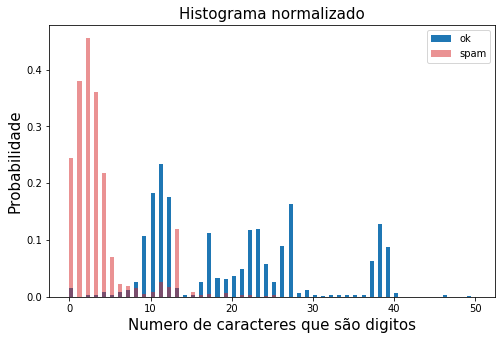

In [13]:
ok_messages = downsampled[downsampled['LABEL'] == 'ok']['NUM_DIGIT_CHARACTERS']
spam_messages = downsampled[downsampled['LABEL'] == 'blocked']['NUM_DIGIT_CHARACTERS']
plot_histogram(ok_messages, spam_messages,[0, 50],xlabel='Numero de caracteres que são digitos')

* Como as mensagens que são spam não tem mais de 15 caractéres que são digitos, enquanto a maioria das mensagens que não são spam estão nessa faixa acima de 15, essa feature também é uma boa candidata para classificação

## 3.5. Normalizando os dados <a name="norma"></a>

* Utilizando o normalizador minMaxScaler, que normaliza os ranges das features entre 0 e 1:

In [14]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
downsampled[['TAMANHO', 'UPPER_CASE',
            'NUM_DIGIT_CHARACTERS']] = scaler.fit_transform(
                downsampled[['TAMANHO', 'UPPER_CASE', 'NUM_DIGIT_CHARACTERS']])
# #converte as labels de blocked para 1 e ok para 0 (spam e nao-spam)
downsampled['LABEL'] = downsampled['LABEL'].map({'blocked': 1, 'ok': 0})
downsampled.head()

,SMS,LABEL,TAMANHO,UPPER_CASE,NUM_DIGIT_CHARACTERS
3823,Osirnet: Seu ip e 132.255.146.39. a Osirnet ag...,0,0.304348,0.029126,0.174603
5186,0500034B0201|Faça login no aplicativo OlympTra...,0,0.416149,0.077670,0.349206
4474,Zabbix_Alfa: PROBLEMA: ISP_BenoitIndisponivel\...,0,0.546584,0.174757,0.365079
4492,Zabbix_Alfa: PROBLEMA: ISP_Teutonet (Seitel)In...,0,0.614907,0.184466,0.365079
1968,"Ei, Adilur, seu CPF 030-xxx.xxx-44 pode sair d...",0,0.838509,0.058252,0.269841


## 3.6. Term Frequency-Inverse Document Frequency (TF-IDF) <a name="tfidf"></a>

A frequência inversa de documentos termo-frequência-inversa (TF-IDF) é uma maneira de julgar o tópico de um artigo pelas palavras que ele contém. Com o TF-IDF, as palavras ganham peso. O TF-IDF mede a relevância, não a frequência. Ou seja, os contadores de palavras são substituídos por pontuações TF-IDF em todo o conjunto de dados.

Primeiro, o TF-IDF mede o número de vezes que as palavras aparecem em um determinado documento (que é "termo frequência"). Porém, palavras como "e" ou "o" aparecem com frequência em todos os documentos, essas devem ser sistematicamente descontadas. Essa é a parte da frequência-inversa de documentos. Quanto em mais documentos uma palavra aparece, menos valiosa é a palavra como sinal para diferenciar qualquer documento, fazendo com que apenas as palavras frequentes e distintas sejam usadas como marcadores. 

A estatística TF-IDF para o termo i no documento j é calculada da seguinte forma:


<div align="center"  style="margin: 20px;">    
$\begin{align}
 TFIDF_{i,j} = TF*IDF
\end{align}$ 
onde:
</div>



<div align="center"  style="margin: 20px;">    
$\begin{align}
 TF_{i,j} = \frac{numero\ de\ vezes\ que\ o\ termo\ i\ esta\ no\ documento\ j}{numero\ total\ de\ termos\ no\ documento\ j}
\end{align}$ 
</div>


<div align="center"  style="margin: 20px;">    
$\begin{align}
 IDF_{i} = ln\left(\frac{numero\ total\ de\ documentos}{numero\ de\ documentos\ contendo\ o\ termo\ i}\right)
\end{align}$ 
</div>

* Aplicando TF-IDF na coluna de mensagens SMS:

In [15]:
vectorizer = TfidfVectorizer()
downsampled_SMS_TFIDF = vectorizer.fit_transform(downsampled['SMS'])
downsampled_SMS_TFIDF

<3000x5143 sparse matrix of type '<class 'numpy.float64'>'
	with 44418 stored elements in Compressed Sparse Row format>

* Pode-se ver que a coluna de SMS, agora foi transformada numa matriz esparsa de 5143 colunas, que é o tamanho do vocabulário identificado pelo conteúdo de cada mensagem

In [16]:
print('tamanho do vocabulário: {}'.format(len(vectorizer.vocabulary_)))

tamanho do vocabulário: 5143


E cada palavra recebe um valor nesse dicionário:

In [17]:
for element in list(vectorizer.vocabulary_)[0:5]:
    print ("PALAVRA: {} - VALOR: {} ".format(element,  vectorizer.vocabulary_[element]))

PALAVRA: osirnet - VALOR: 3935 
PALAVRA: seu - VALOR: 4487 
PALAVRA: ip - VALOR: 3248 
PALAVRA: 132 - VALOR: 563 
PALAVRA: 255 - VALOR: 878 


Agora precisamos substituir a coluna SMS no dataset pelas 5143 calculadas pelo TDIDF:

In [18]:
extracted_features = downsampled.loc[:, [
    'TAMANHO', 'UPPER_CASE', 'NUM_DIGIT_CHARACTERS'
]].values
X = np.hstack((downsampled_SMS_TFIDF.todense(), extracted_features))
y = downsampled['LABEL'].values

In [19]:
print(X.shape)
print(y.shape)

(3000, 5146)
(3000,)


# 4. Criando modelos <a name="modelos"></a>

Estudos como (Almeida, T.A, 2011) e (Sharaff, A., 2019), mostram que Support Vector Machine (SVM), junto com normalização (TF-IDF) trazem bons resultados para classificação de spam, então vamos desenvolver alguns modelos e avaliar suas eficiências para ver se SVM realmente é o melhor.

* Os dados foram separados em dados de treino e dados de teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

Foram importados os modelos:
* Logistic Regreesion
* Support Vector Machine
* Naive Bayes
* Decision Tree
* Random Forest
* Adaboost
* Bagging Classifier
* Extra Trees Classifier

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 

* Os hyperparamêtros dos modelos foram baseados no notebook: https://www.kaggle.com/muzzzdy/spam-detection-classifiers-hyperparameter-tuning

In [22]:
svc = SVC(kernel='sigmoid', gamma=1.0, C=1000)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)
abc = AdaBoostClassifier(n_estimators=62, random_state=42)
bc = BaggingClassifier(n_estimators=9, random_state=42)
etc = ExtraTreesClassifier(n_estimators=9, random_state=42)

In [23]:
clfs = {
    'Support Vector Class.': svc,
    'K-Neighbors': knc,
    'Naive Bayes': mnb,
    'Decision Tree': dtc,
    'Logistic Regression': lrc,
    'Random Forest': rfc,
    'AdaBoost': abc,
    'Bagging Classifier': bc,
    'Extra Tree Classifier': etc
}

## 4.1. Avaliando os modelos <a name="avaliando"></a>

In [24]:
#iterando no dicionario de classificadores, treinando e fazendo predições
pred_scores = []
pred_test = []
for k,v in clfs.items():
    train_classifier(v, X_train, y_train)
    pred = predict_labels(v,X_test)
    pred_test.append((k,[pred]))
    pred_scores.append((k, [accuracy_score(y_test,pred)]))

* Cada modelo foi treinado com os dados e foram feitas predições para os labels, e abaixo pode ser visto a acurácia de cada modelo:

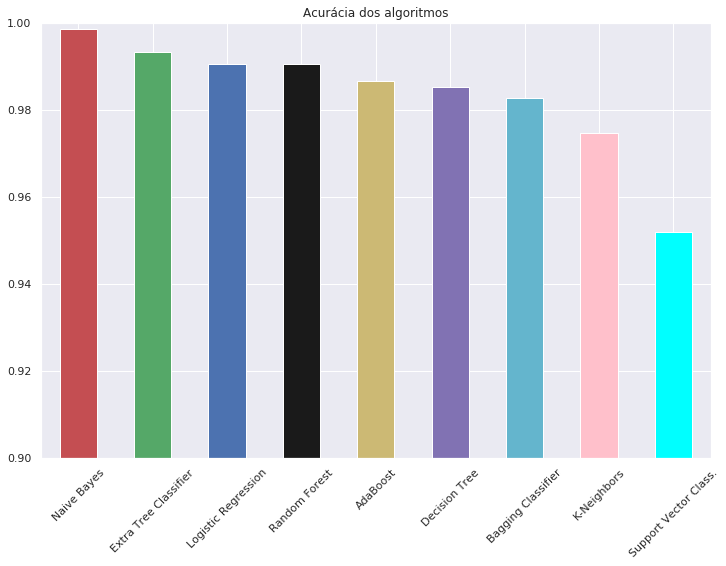

In [25]:
df = pd.DataFrame.from_dict(dict(pred_scores),
                            orient='index',
                            columns=['Score'])
df = df.T
sns.set()
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c', 'pink', 'cyan', 'b']
df.sort_values('Score', ascending=False, inplace=True, axis=1)
df.loc['Score', :].plot(
    kind='bar',
    color=my_colors,
    ylim=(0.9, 1.0),
    figsize=(12, 8),
)

plt.xticks(rotation=45)
plt.title('Acurácia dos algoritmos')
plt.show()

In [26]:
df.head(10)

,Naive Bayes,Extra Tree Classifier,Logistic Regression,Random Forest,AdaBoost,Decision Tree,Bagging Classifier,K-Neighbors,Support Vector Class.
Score,0.998667,0.993333,0.990667,0.990667,0.986667,0.985333,0.982667,0.974667,0.952


Porém, para um problema de classificação, somente a acurácia pode levar a resultados enganosos, por exemplo, num problema de fraude bancária, somente uma porcentagem muito pequenas das transações são fraudulentas, então se o classificador marcar qualquer transação como válida, ainda assim vai obter uma alta acurácia.

Levando isso em conta, existem outras métricas para se avaliar modelos de classificação, como precisão, recall e F1-Score. Para isso pode-se usar uma matriz de confusão:

<a>
    <div style="margin: 20px;">
        <p align="left">
            <img width="40%" align="middle" src="./images/confusion_matrix.png"/>
        </p>
    </div>
</a>

Na matriz de confusão, os elementos tem o seguinte significado:

* True Positive (TP) - Positivos Verdadeiro (spam classificado como spam)
* True Negative (TN) - Negativo Verdadeiro (SMS verdadeiro classificado como SMS verdadeiro)
* False Positive (FP) - Falso Positivo (SMS verdadeiro classificado como spam)
* False Negative (FN) - Falso Negativo (spam classificado como SMS verdadeiro)


Para um classificador de Spams, uma métrica mais interessante é a precisão, que é intuitivamente, a habilidade do classificador de não classificar como positivo, uma amostra que é negativa (classificar um e-mail verdadeiro como spam), definida por:

<div align="center"  style="margin: 20px;">    
$\begin{align}
 Precisão = \frac{TP}{TP + FP}
\end{align}$ 
</div>


* Plotando as matrizes de confusão para cada classificador:

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [28]:
pred_test_ = dict(pred_test)

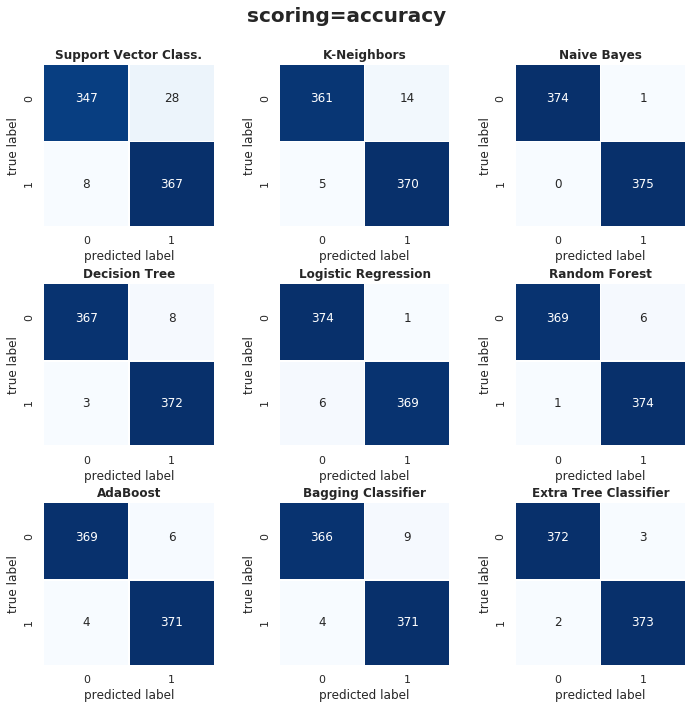

In [29]:
plot_all_confusion_matrices(y_test, pred_test_, "scoring=accuracy")

* Precisão dos classificadores:

In [30]:
list_clf = list(pred_test_.keys())
for clf in list_clf :
    print(clf, " ", precision_score(y_test, pred_test_[clf][0]))

Support Vector Class.   0.9291139240506329
K-Neighbors   0.9635416666666666
Naive Bayes   0.9973404255319149
Decision Tree   0.9789473684210527
Logistic Regression   0.9972972972972973
Random Forest   0.9842105263157894
AdaBoost   0.9840848806366048
Bagging Classifier   0.9763157894736842
Extra Tree Classifier   0.9920212765957447


Então um bom modelo para ser usado, será o Naive Bayes, pois foi o modelo com precisão mais alta.

Para talvez alcançar uma precisão ainda maior:
* Pode ser feito um random search para achar melhores parâmetros para os modelos, contudo é improvável alcançar uma precisão maior que **99.73%** alcançada pelo Naive Bayes.
* Coletar mais dados
* Usar abordagens de deep learning (LSTM,ELMo, BERT)

# 5. Aplicando o modelo nos dados de validação  <a name="aplicando"></a>

* Importando o CSV:

In [31]:
validation_data = pd.read_csv("validation_data.csv")
validation_data.head()

,SMS
0,BB informa:Prezado cliente suas senhas de ACES...
1,BB informa:Prezado cliente suas senhas de ACES...
2,BB informa:Prezado cliente suas senhas de ACES...
3,Node Warning: SFRO01H000001.call.br Warning em...
4,BB informa:Prezado cliente suas senhas de ACES...


* implementando as mensagens SMS no mesmo pipeline de treino e aplicando a predição do modelo treinado anteriormente:

In [32]:
validation_data_labeled = processing_pipeline(validation_data, scaler, vectorizer, mnb)
validation_data_labeled.head()

,SMS,LABEL
0,BB informa:Prezado cliente suas senhas de ACES...,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked


* usando WordCloud podemos ver as palavras mais frequentes que foram classificadas como spam:

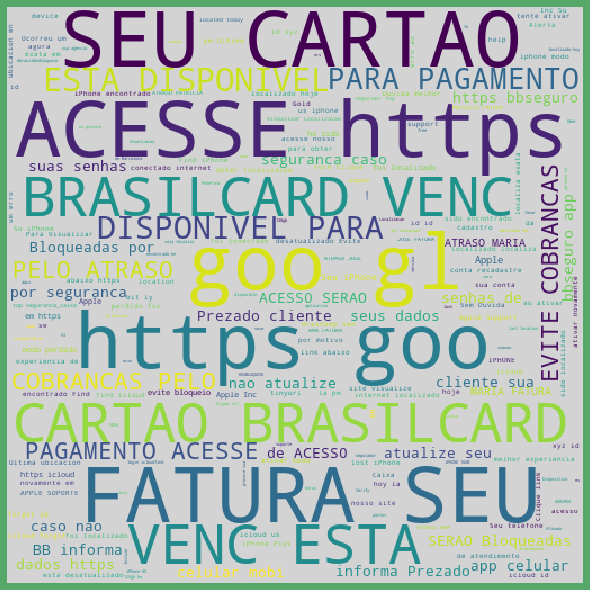

In [34]:
plot_wordcloud(validation_data_labeled)

* O dataframe com as novas predições é salvo no arquivo CSV ('validation_data.csv')

In [35]:
validation_data_labeled.to_csv('./validation_data.csv', index = False, sep=',')

# 6. Referências <a name="ref"></a>

Almeida, T.A., Hidalgo, J.M.G. and Yamakami, A., 2011, September. Contributions to the study of SMS spam filtering: new collection and results. In Proceedings of the 11th ACM symposium on Document engineering (pp. 259-262). ACM.

Delany, S.J., Buckley, M. and Greene, D., 2012. SMS spam filtering: methods and data. Expert Systems with Applications, 39(10), pp.9899-9908.

Tran, K.N., Alazab, M. and Broadhurst, R., 2014. Towards a feature rich model for predicting spam emails containing malicious attachments and urls.

Sharaff, A., 2019. Spam Detection in SMS Based on Feature Selection Techniques. In Emerging Technologies in Data Mining and Information Security (pp. 555-563). Springer, Singapore.